<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Hallucination Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to detecting hallucinations,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [2]:
!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken

In [3]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.experimental.evals import (
    HALLUCINATION_PROMPT_RAILS_MAP,
    HALLUCINATION_PROMPT_TEMPLATE,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include "halueval_qa_data" from the HaluEval benchmark:

- https://arxiv.org/abs/2305.11747
- https://github.com/RUCAIBox/HaluEval

In [4]:
df = download_benchmark_dataset(
    task="binary-hallucination-classification", dataset_name="halueval_qa_data"
)
df.head()

,reference,query,response,is_hallucination
0,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,no,False
1,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,"Yes, Fuyang and Gaozhou are in the same province.",True
2,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"Billboard"" Hot 100",False
3,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"""808"" peaked at number nine on ""Billboard"" Hot 100.",True
4,"""Arms"" then made a comeback in 2017 reaching #36 on the iTunes chart passing Auli'i Cravalho's ""How Far I'll Go"" from the Disney movie ""Moana"" (2017).Moana ( ) is a 2016 American 3D computer-animated musical fantasy-adventure film produced by Walt Disney Animation Studios and released by Walt Disney Pictures.","Arms is a song by American singer-songwriter Christina Perri, in 2017, it passed Auli'i Cravalho's, ""How Far I'll Go"" from which 2016, American 3D computer-animated Disney movie?",Moana,False


## Display Binary Hallucination Classification Template

View the default template used to classify hallucinations. You can tweak this template and evaluate its performance relative to the default.

In [5]:
print(HALLUCINATION_PROMPT_TEMPLATE)


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text. Your response should be a single word: either "factual" or "hallucinated", and
it should not include any other text or characters. "hallucinated" indicates that the answer
provides factually inaccurate information to the query based on the reference text. "factual"
indicates that the answer to the question is correct relative to the reference text, and does not
contain made up inf

Template variables:
- **query** : The question or prompt asked on the context data.
- **reference** : The context data used to answer the question
- **answer** : The answer from the context data, we are checking this answer for halluciations relative to the reference context

## Configure the LLM

Configure your OpenAI API key.

In [6]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

🔑 Enter your OpenAI API key:  ········


## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [7]:
df = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)

## LLM Evals: hallucination Classifications GPT-4
Run hallucination against a subset of the data.

Instantiate the LLM and set parameters.

In [8]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [9]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [10]:
# The rails fore the output to specific values of the template
# It will remove text such as ",,," or "...", anything not the
# binary value expected from the template
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]



Evaluate the predictions against human-labeled ground-truth hallucination labels.

              precision    recall  f1-score   support

hallucinated       0.93      0.87      0.90        45
     factual       0.90      0.95      0.92        55

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

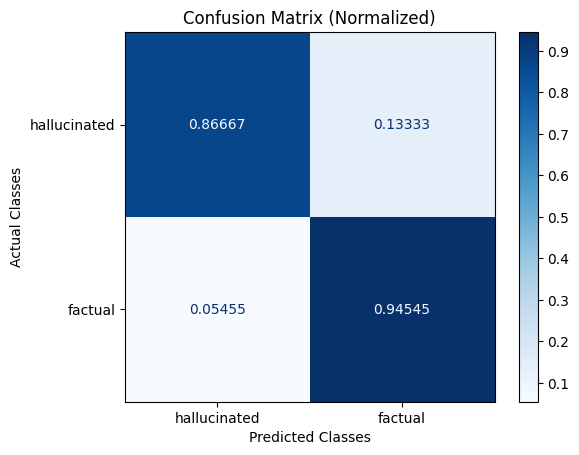

In [11]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
hallucination_classifications = (
    pd.Series(hallucination_classifications)
    .map(lambda x: "unparseable" if x is None else x)
    .tolist()
)
print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=hallucination_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for hallucinations, it can be useful to know why the LLM classified a response as a hallucination or not. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [12]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
hallucination_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
)

Using prompt:


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text.

    [BEGIN DATA]
    ************
    [Query]: {query}
    ************
    [Reference text]: {reference}
    ************
    [Answer]: {response}
    ************
    [END DATA]

    Is the answer above factual or hallucinated based on the query and reference text?

Please read the query, reference text and answer carefully, then write out in a step by step manne

  0%|          | 0/5 [00:00<?, ?it/s]

- Snapped 'factual' to rail: factual
- Snapped 'hallucinated' to rail: hallucinated
- Snapped 'hallucinated' to rail: hallucinated
- Snapped 'hallucinated' to rail: hallucinated
- Snapped 'factual' to rail: factual


In [13]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, hallucination_classifications_df, left_index=True, right_index=True
)
merged_df[["query", "reference", "response", "is_hallucination", "label", "explanation"]].head()

,query,reference,response,is_hallucination,label,explanation
0,"On which bank of the river known in French as ""Fleuve Saint-Jean"" is Nashwaaksis situated?","Nashwaaksis is a neighbourhood and former village in the city of Fredericton, New Brunswick; it is located on the north bank of the Saint John River and at the mouth of the Nashwaaksis Stream, which should not be confused with the larger Nashwaak River nearby.The Saint John River (French: ""Fleuve Saint-Jean"" ; Maliseet: ""Wolastoq""( )) is a river, approximately 418 mi long, located principally in the Canadian province of New Brunswick, but also in and arising from the province of Quebec and the U.S. state of Maine.",north,False,factual,"The query asks for the bank of the river (known in French as 'Fleuve Saint-Jean') on which Nashwaaksis is situated. The reference text clearly states that Nashwaaksis is located on the north bank of the Saint John River (which is the English name for 'Fleuve Saint-Jean'). Therefore, the answer 'north' is factual and based on the information provided in the reference text."
1,"What choreographer for the Indian version of BBC's ""Strictly Come Dancing"" is currently judging Maharashtracha Dancing Superstar - Chhotte Masters?","Savio Barnes (Hindi: सवियो बार्न्स) is a popular Bollywood Dance choreographer, actor and dancer. He came to fame after choreographing many dances for Jhalak Dikhhla Jaa, a dance-competition. Currently Savio is judging the Marathi dance reality show Maharashtracha Dancing Superstar - Chhotte Masters.Jhalak Dikhhla Jaa is a television reality show and the Indian version of BBC's ""Strictly Come Dancing"".",Savio Barnes was a participant in Jhalak Dikhhla Jaa before becoming a choreographer and judge.,True,hallucinated,"The answer states that Savio Barnes was a participant in Jhalak Dikhhla Jaa before becoming a choreographer and judge. However, the reference text does not provide any information about Savio Barnes being a participant in the show. It only mentions that he came to fame after choreographing many dances for Jhalak Dikhhla Jaa and is currently judging the Marathi dance reality show Maharashtracha Dancing Superstar - Chhotte Masters. Therefore, the answer is hallucinated as it assumes information that is not available in the reference text."
2,"The Valigeria Franzi was an Italian manufacturer of leather bags and luggage founded in Milan in 1864 by Rocco Franzi, Guccio Gucci worked for the company until he set up Gucci in what year, an Italian luxury brand of fashion and leather goods, part of the Gucci Group, which is owned by the French holding company Kering?",Guccio Gucci worked for the company until he set up Gucci in 1921. Gucci was founded by Guccio Gucci in Florence in 1921.,Guccio Gucci set up Gucci in 1922.,True,hallucinated,"The reference text clearly states that Guccio Gucci set up Gucci in 1921. However, the answer claims that Guccio Gucci set up Gucci in 1922. This is a contradiction, and since the answer does not align with the information provided in the reference text, it can be considered a hallucination."
3,"Thomas Ritter is a retired German footballer who played one game for Germany in 1993 against Uruguay, as a substitute for Stefan Effenberg, a retired German footballer who last managed what club?","Thomas Ritter (born 10 October 1967 in Görlitz) is a retired German footballer. He played one game for Germany on 13 October 1993 in a friendly against Uruguay, as a substitute for Stefan Effenberg.Stefan Effenberg (] ; born 2 August 1968) is a retired German footballer who last managed SC Paderborn.",Stefan Effenberg last managed Borussia Mönchengladbach.,True,hallucinated,"The answer states that Stefan Effenberg last managed Borussia Mönchengladbach. However, according to the reference text, Stefan Effenberg last managed SC Paderborn. Therefore, the answer is hallucinated as it provides factually inaccurate information based on the reference text."
4,"Are the bands ""Halestorm"" and ""Sa

## LLM Evals: hallucination Classifications GPT-3.5
Run hallucination against a subset of the data.

In [14]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [15]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

hallucinated       0.97      0.78      0.86        45
     factual       0.84      0.98      0.91        55

    accuracy                           0.89       100
   macro avg       0.91      0.88      0.89       100
weighted avg       0.90      0.89      0.89       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

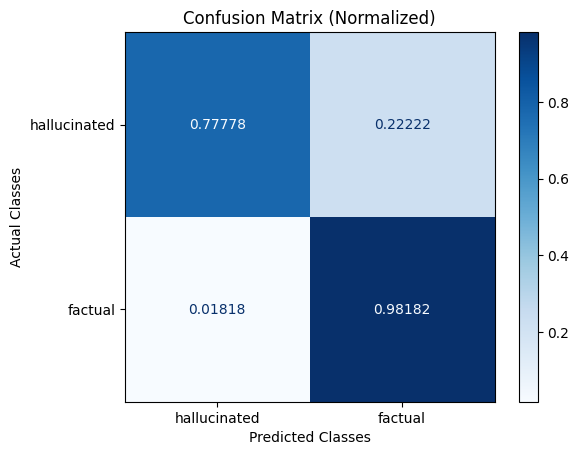

In [16]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
hallucination_classifications = (
    pd.Series(hallucination_classifications)
    .map(lambda x: "unparseable" if x is None else x)
    .tolist()
)

print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=hallucination_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

# Preview: GPT-4 Turbo

In [17]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=OpenAIModel(model_name="gpt-4-1106-preview", temperature=0.0),
    rails=rails,
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

hallucinated       0.97      0.78      0.86        45
     factual       0.84      0.98      0.91        55

    accuracy                           0.89       100
   macro avg       0.91      0.88      0.89       100
weighted avg       0.90      0.89      0.89       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

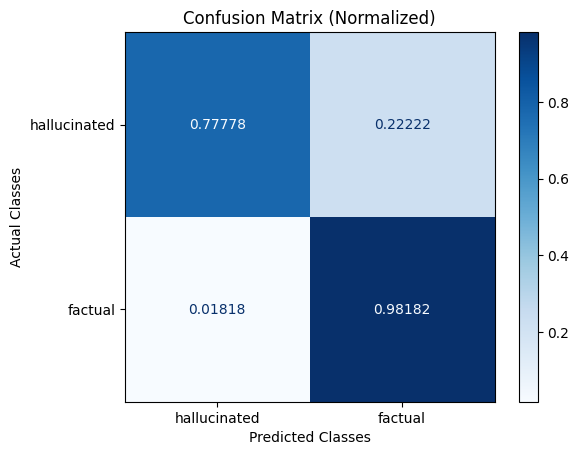

In [18]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
hallucination_classifications = (
    pd.Series(hallucination_classifications)
    .map(lambda x: "unparseable" if x is None else x)
    .tolist()
)

print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=hallucination_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)